#### imports

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import pickle
## from SCRIPT.eval_tools import *
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from matplotlib import rcParams
import folium
import json
from urllib.request import urlopen
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

#### let's load some data! 🥒

In [2]:
with open('pickles/timeseries_sac_p.pkl', 'rb') as fp:
    sac_p = pickle.load(fp)

In [3]:
sac_p.index = pd.DatetimeIndex(sac_p.index.values, freq='infer')

In [4]:
sac_p.columns = sac_p.columns.astype(str)

In [5]:
trdf = sac_p.iloc[:-40]

In [6]:
select_zipcode = ['95630', '95608', '95818', '95632', '95824']

In [7]:
trdf.describe().T.describe()[['mean', 'min', 'max']]

,mean,min,max
count,48.000000,48.000000,48.000000
mean,704.684871,-5.045066,162690.125000
std,208.387702,5.878197,48142.030432
min,399.710285,-40.434235,92194.000000
25%,553.628667,-4.262511,127799.750000
50%,679.192468,-3.796601,156790.000000
75%,823.787166,-3.363537,190210.000000
max,1352.863978,-2.526268,312427.000000


In [8]:
zip_1 = select_zipcode[0]
sel_df1 = sac_p[zip_1]
zip_2 = select_zipcode[1]
sel_df2 = sac_p[zip_2]
zip_3 = select_zipcode[2]
sel_df3 = sac_p[zip_3]
zip_4 = select_zipcode[3]
sel_df4 = sac_p[zip_4]
zip_5 = select_zipcode[4]
sel_df5 = sac_p[zip_5]

#### baseline

In [1]:
#persistence algorithm, which predicts the value to be the same as the last observed value.

In [9]:
def RMSE(y_true, y_pred):
    return sqrt(MSE(y_true, y_pred))

In [10]:
def get_RMSE(data, model, term = 40, show = True):
    pred = model.get_prediction(-term)
    pred_ci = pred.conf_int()
    sel_dat = data[-term:]
    rmse = RMSE(sel_dat, pred.predicted_mean)
    if show:
        ax = data.plot(label='observed', figsize=(8, 6))
        pred.predicted_mean.plot(ax=ax, label='predicted')
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=0.1)
        ax.set_xlabel('Date')
        ax.set_ylabel('Percent Increase')
        
        plt.legend(loc='best')
        plt.show()
    return rmse

In [108]:
baseline_RMSE = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    pred = df.shift()[-40:]
    y_test = df[-40:]
    baseline_RMSE.append(RMSE(y_test, pred))

In [109]:
results = pd.DataFrame(baseline_RMSE, columns = ['baseline'])

In [110]:
baseline_RMSE2 = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    y_train = [np.mean(df[:-40])] * 40
    y_test = df[-40:]
    baseline_RMSE2.append(RMSE(y_test, pred))

In [111]:
results['historic_avg'] = baseline_RMSE2

### zipCode 95630 

#### plot moving average and sd

In [126]:
def plot_moving_avg(series, window, zipcode = ''):
    rolling_mean = series.rolling(window = window).mean()
    rolling_sd = series.rolling(window = window).std()
    plt.figure(figsize = (10, 6))
    plt.plot(series, label = 'Actual Values', lw = 2)    
    plt.plot(rolling_mean, '--', label = 'Rolling Mean', lw = 2)
    plt.plot(rolling_sd, '--', label = 'Rolling St. Dev', lw = 2)
    plt.legend()
    plt.ylabel('Percent Increase')
    plt.title(f'{window} Months Rolling Trend ({zipcode})')
    plt.show()

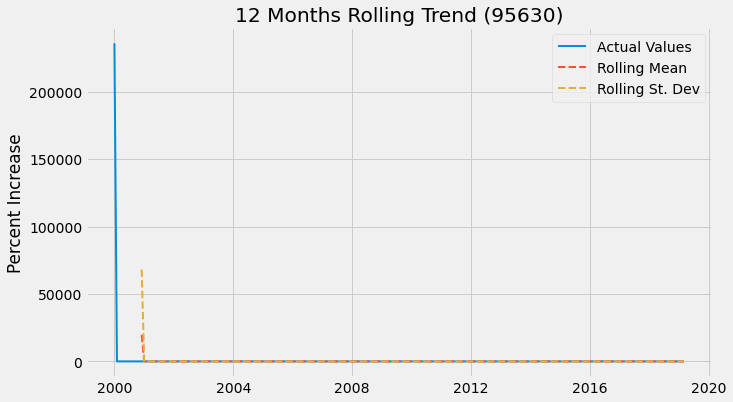

In [127]:
plot_moving_avg(sel_df1[:-40], 12, zip_1)

In [114]:
def run_dickyey_fuller(series, title):
    result = adfuller(series)
    p = result[1]
    if p < 0.05:
        print(f'Null Rejected (p = {round(p, 4)}). {title} time series is stationary')
    else: 
        print(f'Failed to reject the null (p = {round(p, 4)}). {title} time series is not stationary')

In [115]:
run_dickyey_fuller(sel_df1[:-40], zip_1)

Failed to reject the null (p = 0.1115). 95630 time series is not stationary


In [116]:
def plot_decomposition(series, zipcode = ''):
    rcParams['figure.figsize'] = 12,6
    seasonal_decompose(series).plot()
    plt.xlabel(f'year ({zipcode})')
    plt.show()

    

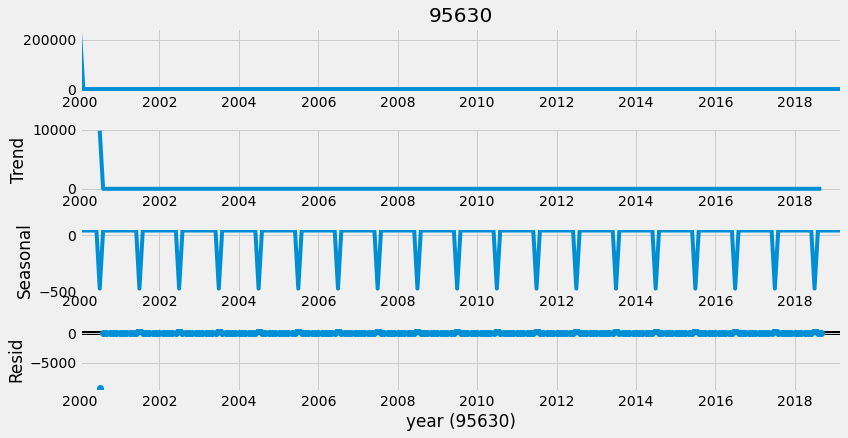

In [117]:
plot_decomposition(sel_df1[:-40], zip_1)

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


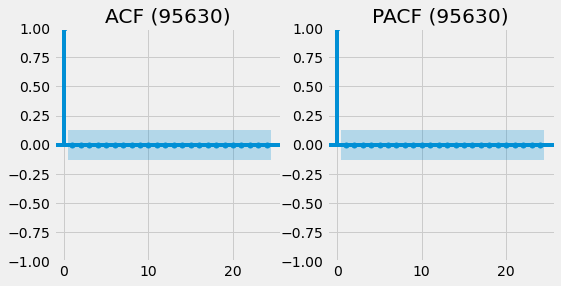

In [118]:
def def_acf_pacf(series, zipcode):
    plt.figure(figsize = (8, 4))
    ax1 = plt.subplot(1, 2, 1)
    plot_acf(series, ax = ax1, alpha = 0.05)
    plt.title(f'ACF ({zipcode})')
    ax2 = plt.subplot(1, 2, 2)
    plot_pacf(series, ax = ax2, alpha = 0.05)
    plt.title(f'PACF ({zipcode})')
    plt.show()


def_acf_pacf(sel_df1[:-40], zip_1)

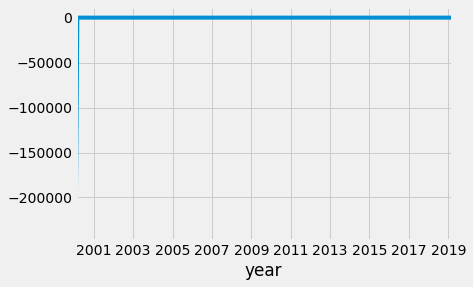

In [53]:
def plot_basic(series, xlabel = 'year', ylabel = '', title = ''):
    ''' return basic time series plot ''' 
    plt.figure(figsize = (6, 4))
    series.plot()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()



plot_basic(sel_df1[:-40].diff(1)[1:])

In [54]:
run_dickyey_fuller(sel_df1[:-40].diff(1)[1:], zip_1)

Null Rejected (p = 0.0043). 95630 time series is stationary


In [84]:
def find_sarima_param(df, max_range = 2, 
                      p = range(0, 2), 
                      q = range(0, 2),
                      d = range(0, 2),
                      s = 12, thresh = 500):
    '''find the best sarima params'''
    
    pdq = list(product(p, d, q))
    spdq = [x + (s,) for x in pdq]
    min_param = [None, None, thresh]

    for param in pdq:
        for sparam in spdq:
            try:
                mod = SARIMAX(df, order=param,
                              seasonal_order=sparam)
                results = mod.fit()

                if results.aic < min_param[2]: 
                    min_param[0] = param
                    min_param[1] = sparam
                    min_param[2] = results.aic
            except:
                continue
    print(f'pdq: {min_param[0]}, PDQS: {min_param[1]} - AIC: {round(min_param[2], 2)}')
    return min_param[0], min_param[1]


In [58]:
pdq, SPDQ = find_sarima_param(sel_df1[:-40])

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq: (0, 0, 1), PDQS: (1, 1, 0, 12) - AIC: 6.0


C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


#### covariance matrix

In [59]:
sarima = SARIMAX(sel_df1[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model1 = sarima.fit()
print(sarima_model1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               95630   No. Observations:                  231
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -297.546
Date:                             Sun, 28 Aug 2022   AIC                            601.092
Time:                                     21:57:56   BIC                            611.090
Sample:                                 01-01-2000   HQIC                           605.135
                                      - 03-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8422      0.028     29.832      0.000       0.787       0.898
ar.S.L12       0.0007    4.

In [119]:
# Warnings:⚠️[1] Covariance matrix calculated using the outer product of gradients (complex-step).
# more like a "note" than a "warning". It's just letting you know how the covariance matrix 
# was computed.

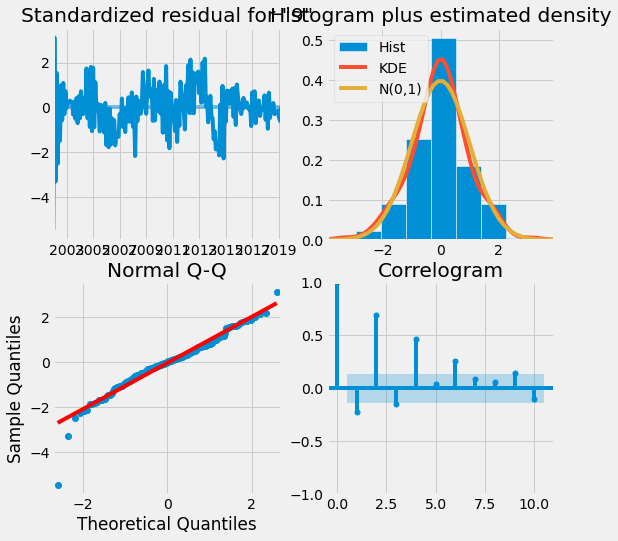

In [60]:
sarima_model1.plot_diagnostics(figsize = (8, 8))
plt.show()

In [121]:
def rolling_forecast(df, pdq, SPDQ, term = 40):
    train = df[:-term]
    test = df[-term:]
    hist = list(train)
    pred = list()
    for term in range(len(test)):
        model = SARIMAX(hist, order = pdq, 
                        seasonal_order = SPDQ,enforce_stationarity=False) 
        fit = model.fit(disp=0)
        pred.append(fit.forecast()[0])
        hist.append(test[term]) 
    return train, test, hist, pred

In [122]:

def test_RMSE(df, pdq, SPDQ, term = 40, show = True):
    ''' get RMSE for test set '''
    _, test, _, pred = rolling_forecast(df, pdq, SPDQ, term = term)
    
    if show:
        plt.figure(figsize=(8, 6))
        plt.plot(df, label='true')
        plt.plot(test.index, pred, label='Forecast')
        plt.xlabel('Date')
        plt.ylabel('Percent Increase')        
        plt.legend(loc='best')
        plt.title('Rolling Forecasting On Test Set')
        plt.show()
    return RMSE(test, pred)

In [94]:
# got; LinAlgError: LU decomposition error. ⚠️

#### let's check for nans

In [93]:
from scipy import linalg
print(linalg.lapack.dgetrf([np.nan]))
print(linalg.lapack.dgetrf([np.inf]))

(array([nan]), array([0], dtype=int32), 0)
(array([inf]), array([0], dtype=int32), 0)


#### *Solved!*   🎈

In [125]:
# got; LinAlgError: LU decomposition error. ⚠️
#added-enforce_stationarity=False) 
#model = SARIMAX(hist, order = pdq, 
                       # seasonal_order = SPDQ, enforce_stationarity=False)
    
#### What did this parameter do exactly? ...even the guy that suggested fix didn't know

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


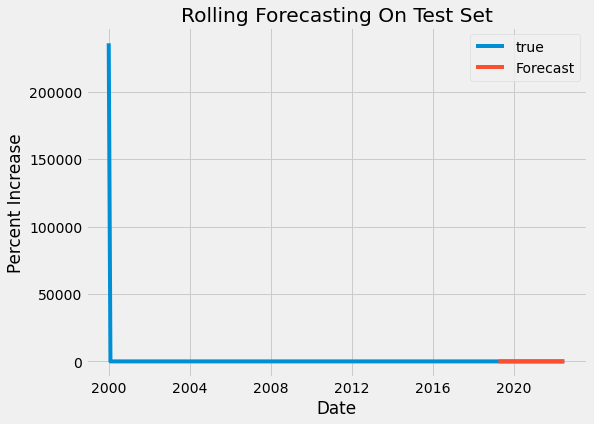

In [123]:
rmse_1 = test_RMSE(sel_df1, pdq, SPDQ)